Preamble

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.table import Table

Plotting functions

In [2]:
def scatter_hist(ax, x, y, xlim=None, ylim=None, log_norm=True, cmap='gray',
                 cmin=10, vmin=None, vmax=None, nbins=50, color='k'):
    """
    Generate a scatter plot and overlayed 2D histogram for dense data.

    Parameters
    ----------
    ax : matplotlib.axis.Axes
        Axes object on which to plot the data.
    x : array-like
        Horizontal coordinates of the data points.
    y : array-like
        Vertical coordinates of the data points.
    xlim : float, optional
        Bounds for x-axis. The default is None.
    ylim : float, optional
        Bounds for y-axis. The default is None.
    log_norm : bool, optional
        Shade the 2D histogram on a logarithmic scale. The default is True.
    cmap : str, optional
        Colormap for 2D histogram. The default is'gray'.
    cmin : int, optional
        Minimum counts per bin; any number below this will show individual points.
        The default is 10.
    vmin : float or None, optional
        Value to map to minimum of histogram normalization. The default is None.
    vmax : float or None, optional
        Value to map to maximum of histogram normalization. The default is None.
    nbins : int or tuple of ints, optional
        Number of histogram bins. If a tuple, presumed to be (xbins, ybins).
        The default is 50.
    color : str, optional
        Color of individual points. The default is 'k'.

    Returns
    -------
    matplotlib.axis.Axes

    """
    # Set automatic plot bounds
    if not xlim:
        xlim = (np.min(x), np.max(x))
    if not ylim:
        ylim = (np.min(y), np.max(y))
    # Set bin edges
    if type(nbins) == 'tuple':
        xbins, ybins = nbins
    else:
        xbins = ybins = nbins
    xbins = np.linspace(xlim[0], xlim[1], num=xbins, endpoint=True)
    ybins = np.linspace(ylim[0], ylim[1], num=ybins, endpoint=True)
    # Histogram normalization
    if log_norm:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
    ax.scatter(x, y, c=color, s=0.5)
    ax.hist2d(x, y, bins=[xbins, ybins], cmap=cmap, norm=norm, cmin=cmin)
        
    dx = xbins[1] - xbins[0]
    dy = ybins[1] - ybins[0]
    ax.set_xlim((xlim[0] - 2*dx, xlim[1] + 2*dx))
    ax.set_ylim((ylim[0] - 2*dy, ylim[1] + 2*dy))
    
    return ax

Import ASPCAP allStar file and make some preliminary quality cuts.
Also remove any entries without a 2MASS ID (a very small percentage).

In [3]:
aspcap_path = Path("data/allStarLite-dr17-synspec.fits")
# Import APOGEE allStar data
aspcap_table = Table.read(aspcap_path, format='fits', hdu=1)
# Separate paramflags into individual columns
for i in range(len(aspcap_table['PARAMFLAG'][0])):
    aspcap_table['PARAMFLAG' + str(i)] = aspcap_table['PARAMFLAG'][:,i]
# Filter out multidimensional columns
cols = [name for name in aspcap_table.colnames if len(aspcap_table[name].shape) <= 1]

def decode(df):
    """
    Decode DataFrame with byte strings into ordinary strings.
    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

# Convert byte-strings to ordinary strings and convert to pandas
aspcap_df = decode(aspcap_table[cols].to_pandas())
# Drop duplicate targets, keeping highest adjusted SNR
aspcap_df = aspcap_df.sort_values(['APOGEE_ID', 'SNREV'])\
                     .drop_duplicates(subset='APOGEE_ID', keep='last')\
                     .sort_index()
# Replace NaN stand-in values with NaN
aspcap_df.replace(99.999, np.nan, inplace=True)
# Replace NaN in ASPCAPFLAGS with empty string
aspcap_df["ASPCAPFLAGS"].replace(np.nan, "", inplace=True)
# Replace '' with 'none' in columns of type 'object'
# aspcap_df.replace('', 'none', inplace=True)
# Remove VESTA
aspcap_df.drop(0, inplace=True)
# Weed out bad flags
fatal_flags = (2**23) # STAR_BAD
aspcap_df = aspcap_df[aspcap_df["ASPCAPFLAG"] & fatal_flags == 0]
aspcap_df.reset_index(inplace=True, drop=True)
# Copy 2Mass ID column without "2M" prefix
# also limit to targets with a 2Mass ID
aspcap_df = aspcap_df[aspcap_df["APOGEE_ID"].str.contains("2M")]
aspcap_df["TMASS_ID"] = [id[2:] for id in aspcap_df.APOGEE_ID.tolist()]
aspcap_df["TMASS_ID"].to_csv("data/apogee_tmass_ids.csv", index=False, header=False)

aspcap_df

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,PARAMFLAG0,PARAMFLAG1,PARAMFLAG2,PARAMFLAG3,PARAMFLAG4,PARAMFLAG5,PARAMFLAG6,PARAMFLAG7,PARAMFLAG8,TMASS_ID
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,0,33554432,0,0,0,0,0,0,0,00000002+7417074
1,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,0.022,...,0,0,288,0,0,256,0,0,0,00000019-1924498
2,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,0,0,0,0,0,32,0,0,0,00000032+5737103
3,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,32,33554464,32,32,32,32,32,0,0,00000035-7323394
4,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,0,33554432,32,0,0,0,0,0,0,00000068+5710233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622238,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,0,33554464,0,0,32,32,32,0,0,23595867-7339039
622239,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,0,16777216,0,0,0,0,0,0,0,23595886+5726058
622240,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,0,33554432,0,0,0,0,0,0,0,23595921+5609479
622241,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,0,33554464,0,0,32,32,32,0,0,23595949-7342592


Import GALAH

In [210]:
galah_path = Path("data/GALAH_DR3_main_allstar_v2.fits")
galah_table = Table.read(galah_path, format="fits")
galah_df = decode(galah_table.to_pandas())
galah_df = galah_df[(galah_df["snr_c3_iraf"] > 30) &
                    (galah_df["flag_sp"] == 0) &
                    (galah_df["flag_fe_h"] == 0)]
# TODO also limit to flag_X_fe for any elemental abundance X
galah_df

,star_id,sobject_id,dr2_source_id,dr3_source_id,survey_name,field_id,flag_repeat,wg4_field,wg4_pipeline,flag_sp,...,ks_m,ks_msigcom,ph_qual_tmass,w2mpro,w2mpro_error,ph_qual_wise,a_ks,e_a_ks,bc_ks,ruwe_dr2
0,03325271-6840304,131116000501002,4667368899326730240,4667368899326730240,galah_main,138,0,10k_2,lbol,0,...,10.607,0.021,AAA,10.558,0.019,AAAU,0.082620,0.026685,2.198110,1.098764
8,03405609-6844483,131116000501012,4667320108498311168,4667320108498311168,galah_main,138,0,10k_44,lbol,0,...,11.926,0.023,AAA,11.939,0.021,AABC,0.010098,0.028591,1.549377,1.027320
9,03403587-6844432,131116000501013,4667320795693075456,4667320795693075456,galah_main,138,0,10k_20,lbol,0,...,11.405,0.026,AAA,11.424,0.020,AAAU,0.011934,0.027980,1.958494,1.189190
11,03402113-6848514,131116000501015,4667319455663284224,4667319455663284224,galah_main,138,0,10k_49,lbol,0,...,12.340,0.029,AAA,12.316,0.021,AABU,0.000000,0.031400,1.455364,1.001337
12,03394376-6848101,131116000501018,4667319043346417664,4667319043346417664,galah_main,138,0,10k_15,lbol,0,...,11.239,0.021,AAA,11.235,0.020,AAAU,0.015606,0.030113,2.103191,1.075210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588566,15142072-4415325,190225005301395,6003344796319529984,6003344796319529984,galah_main,4235,0,190225,lbol,0,...,6.438,0.020,AAA,6.453,0.025,AAAA,0.080784,0.046457,2.122558,0.841033
588567,15151322-4415182,190225005301396,6000435312445129728,6000435312445129728,galah_main,4235,0,190225,lbol,0,...,10.139,0.021,AAA,10.102,0.020,AAAU,0.024786,0.026622,1.232041,0.915573
588568,15162269-4414571,190225005301397,6000421607212226560,6000421607212226560,galah_main,4235,0,190225,lbol,0,...,7.364,0.026,AAA,7.309,0.020,AAAB,0.155142,0.044369,2.401451,1.114932
588569,15161847-4418028,190225005301398,6000420675196587008,6000420675196587008,galah_main,4235,0,190225,lbol,0,...,8.810,0.019,AAA,8.841,0.020,BAAB,0.045900,0.041054,1.967848,0.926810


Import astrophysical parameters from Gaia DR3.

In [4]:
gaia_astro = pd.read_csv("data/gaia_astrophysical_parameters.csv", 
                          dtype={"classlabel_espels": "object"})
gaia_astro.set_index("original_ext_source_id", inplace=True)
gaia_astro.drop_duplicates(inplace=True)
gaia_astro

,source_id,ra,dec,solution_id,source_id.1,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,classprob_dsc_combmod_whitedwarf,classprob_dsc_combmod_binarystar,...,ag_msc_upper,ag_msc_lower,logposterior_msc,mcmcaccept_msc,mcmcdrift_msc,flags_msc,neuron_oa_id,neuron_oa_dist,neuron_oa_dist_percentile_rank,flags_oa
original_ext_source_id,,,,,,,,,,,,,,,,,,,,,
00000002+7417074,538028216707715712,0.000205,74.285436,1636148068921376768,538028216707715712,1.029028e-13,5.139943e-13,0.999913,2.019855e-12,0.000087,...,0.669155,0.635234,-605880.80000,0.304487,1.211973,1.0,NaN,NaN,NaN,NaN
00000019-1924498,2413929812587459072,0.000970,-19.413922,1636148068921376768,2413929812587459072,1.047278e-13,5.231100e-13,0.999732,1.868176e-09,0.000268,...,0.204702,0.126441,394.37555,0.294726,0.033347,0.0,NaN,NaN,NaN,NaN
00000032+5737103,422596679964513792,0.001332,57.619507,1636148068921376768,422596679964513792,1.022279e-13,5.106234e-13,0.999980,1.723692e-10,0.000020,...,0.928979,0.475252,-1288.87620,0.140406,0.099076,1.0,NaN,NaN,NaN,NaN
00000035-7323394,4689447878791422208,0.001481,-73.394323,1636148068921376768,4689447878791422208,1.020988e-13,5.523579e-13,0.999994,5.982815e-10,0.000006,...,0.768308,0.000000,102.58035,0.230191,0.071842,0.0,NaN,NaN,NaN,NaN
00000068+5710233,421077597267551104,0.002913,57.173075,1636148068921376768,421077597267551104,1.023049e-13,5.110079e-13,0.999972,2.008120e-12,0.000028,...,0.919130,0.353034,-21008.60700,0.147947,0.047836,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23595886-2009435,2341765776376373376,359.995295,-20.162166,1636148068921376768,2341765776376373376,1.029946e-13,5.144531e-13,0.999904,2.021658e-12,0.000096,...,0.439015,0.000000,603.45550,0.144057,0.031283,0.0,NaN,NaN,NaN,NaN
23595886+5726058,1998097371124974720,359.995268,57.434918,1636148068921376768,1998097371124974720,1.020373e-13,5.096712e-13,0.999999,2.002867e-12,0.000001,...,0.439536,0.420394,-29813.63300,0.299332,0.678233,1.0,NaN,NaN,NaN,NaN
23595921+5609479,1994741318040223232,359.996716,56.163345,1636148068921376768,1994741318040223232,1.020473e-13,5.097213e-13,0.999998,2.003064e-12,0.000002,...,2.164036,0.091880,-16314.74500,0.240167,0.105819,1.0,NaN,NaN,NaN,NaN


In [5]:
alldata = aspcap_df.copy()
alldata.set_index("TMASS_ID", inplace=True,drop=True)
alldata = alldata.join(gaia_astro, how="inner")
alldata

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,ag_msc_upper,ag_msc_lower,logposterior_msc,mcmcaccept_msc,mcmcdrift_msc,flags_msc,neuron_oa_id,neuron_oa_dist,neuron_oa_dist_percentile_rank,flags_oa
00000002+7417074,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,0.669155,0.635234,-605880.80000,0.304487,1.211973,1.0,NaN,NaN,NaN,NaN
00000019-1924498,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,0.022,...,0.204702,0.126441,394.37555,0.294726,0.033347,0.0,NaN,NaN,NaN,NaN
00000032+5737103,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,0.928979,0.475252,-1288.87620,0.140406,0.099076,1.0,NaN,NaN,NaN,NaN
00000035-7323394,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,0.768308,0.000000,102.58035,0.230191,0.071842,0.0,NaN,NaN,NaN,NaN
00000068+5710233,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,0.919130,0.353034,-21008.60700,0.147947,0.047836,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23595867-7339039,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,0.409695,0.000000,151.24228,0.262053,0.098688,0.0,NaN,NaN,NaN,NaN
23595886+5726058,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,0.439536,0.420394,-29813.63300,0.299332,0.678233,1.0,NaN,NaN,NaN,NaN
23595921+5609479,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,2.164036,0.091880,-16314.74500,0.240167,0.105819,1.0,NaN,NaN,NaN,NaN
23595949-7342592,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,0.663985,0.000000,149.14719,0.238687,0.012151,0.0,NaN,NaN,NaN,NaN


Import Gaia DR3 parameters

In [15]:
gaia_source = Table.read("data/gaia_apogee_source.fits.gz", format="fits")
gaia_source_df = decode(gaia_source.to_pandas())
# drop duplicates
gaia_source_df = gaia_source_df.sort_values(
    ["original_ext_source_id", "has_rvs", "random_index"])\
              .drop_duplicates(subset="original_ext_source_id", keep="last")\
              .sort_index()
gaia_source_df.set_index("original_ext_source_id", drop=True, inplace=True)
alldata = alldata.join(gaia_source_df, how="inner", rsuffix="_source")
alldata

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,azero_gspphot_source,azero_gspphot_lower_source,azero_gspphot_upper_source,ag_gspphot_source,ag_gspphot_lower_source,ag_gspphot_upper_source,ebpminrp_gspphot_source,ebpminrp_gspphot_lower_source,ebpminrp_gspphot_upper_source,libname_gspphot_source
00000002+7417074,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,1.9282,1.8881,1.9881,1.2574,1.2309,1.2965,0.7237,0.7098,0.7447,MARCS
00000019-1924498,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,0.022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000032+5737103,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,0.9775,0.9732,0.9825,0.8216,0.8178,0.8260,0.4470,0.4449,0.4494,A
00000035-7323394,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,0.5777,0.5578,0.5954,0.4457,0.4300,0.4599,0.2347,0.2263,0.2422,PHOENIX
00000068+5710233,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23595867-7339039,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,0.9363,0.9045,0.9643,0.7397,0.7138,0.7628,0.3938,0.3799,0.4064,PHOENIX
23595886+5726058,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,2.1558,2.1438,2.1685,1.6286,1.6185,1.6393,0.8748,0.8689,0.8809,MARCS
23595921+5609479,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23595949-7342592,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,0.7473,0.7057,0.7857,0.5817,0.5486,0.6125,0.3084,0.2909,0.3247,PHOENIX


In [19]:
rg = alldata[(alldata["TEFF"] < 6000) & (alldata["LOGG"] < 4)]

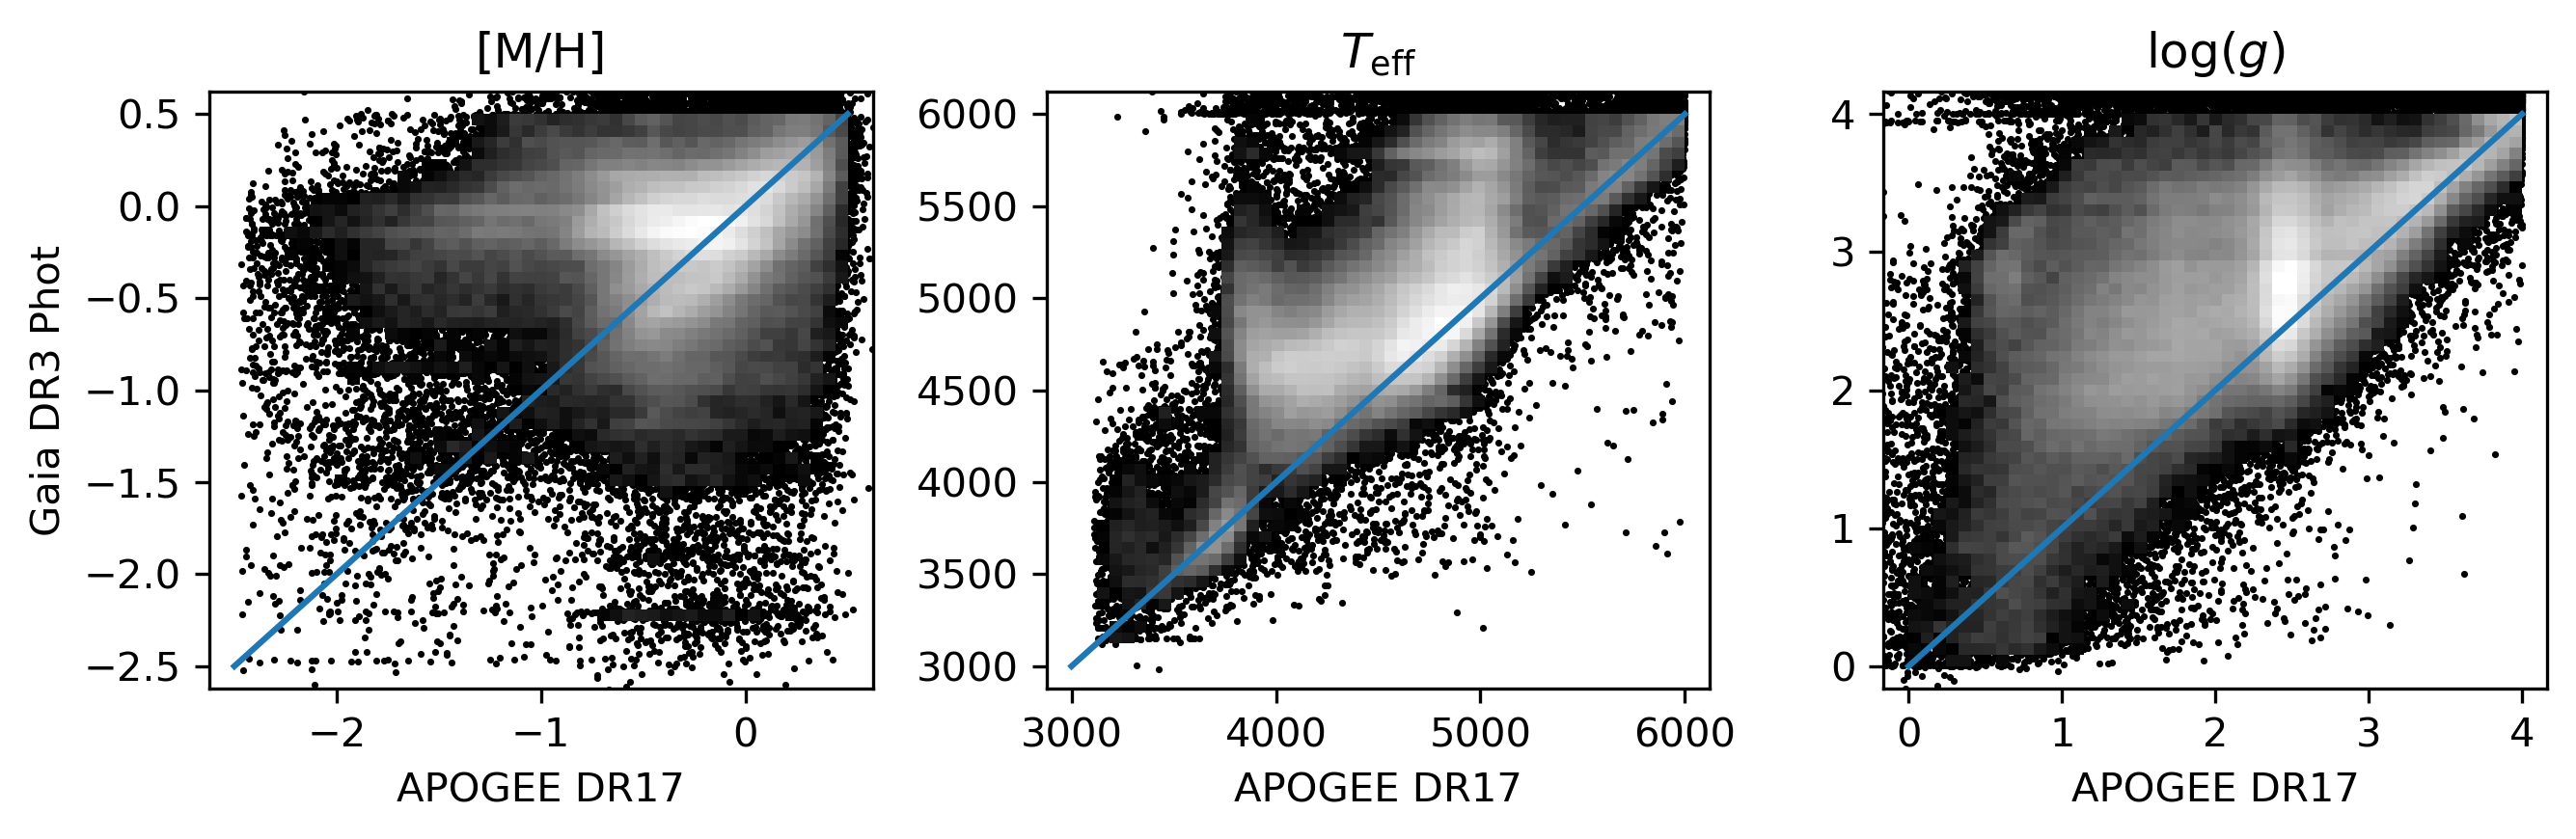

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=300, tight_layout=True)
scatter_hist(axs[0], rg["M_H"], rg["mh_gspphot"], xlim=(-2.5, 0.5), ylim=(-2.5, 0.5))
# axs[0].scatter(rg["M_H"], rg["mh_gspphot"], s=0.1, c='k')
axs[0].plot([-2.5, 0.5], [-2.5, 0.5])
axs[0].set_xlabel("APOGEE DR17")
axs[0].set_ylabel("Gaia DR3 Phot")
axs[0].set_title("[M/H]")
scatter_hist(axs[1], rg["TEFF"], rg["teff_gspphot"], xlim=(3000, 6000), ylim=(3000, 6000))
# axs[1].scatter(rg["TEFF"], rg["teff_gspphot"], s=0.1, c=rg["M_H"])
axs[1].plot([3000, 6000], [3000, 6000])
# axs[1].set_ylim((2900, 6100))
axs[1].set_xlabel("APOGEE DR17")
axs[1].set_title(r"$T_{\rm{eff}}$")
scatter_hist(axs[2], rg["LOGG"], rg["logg_gspphot"], xlim=(0, 4), ylim=(0, 4))
# axs[2].scatter(rg["LOGG"], rg["logg_gspphot"], s=0.1, c=rg["M_H"])
axs[2].plot([0, 4], [0, 4])
# axs[2].set_ylim((-1, 5))
axs[2].set_xlabel("APOGEE DR17")
axs[2].set_title(r"$\log(g)$")
plt.show()

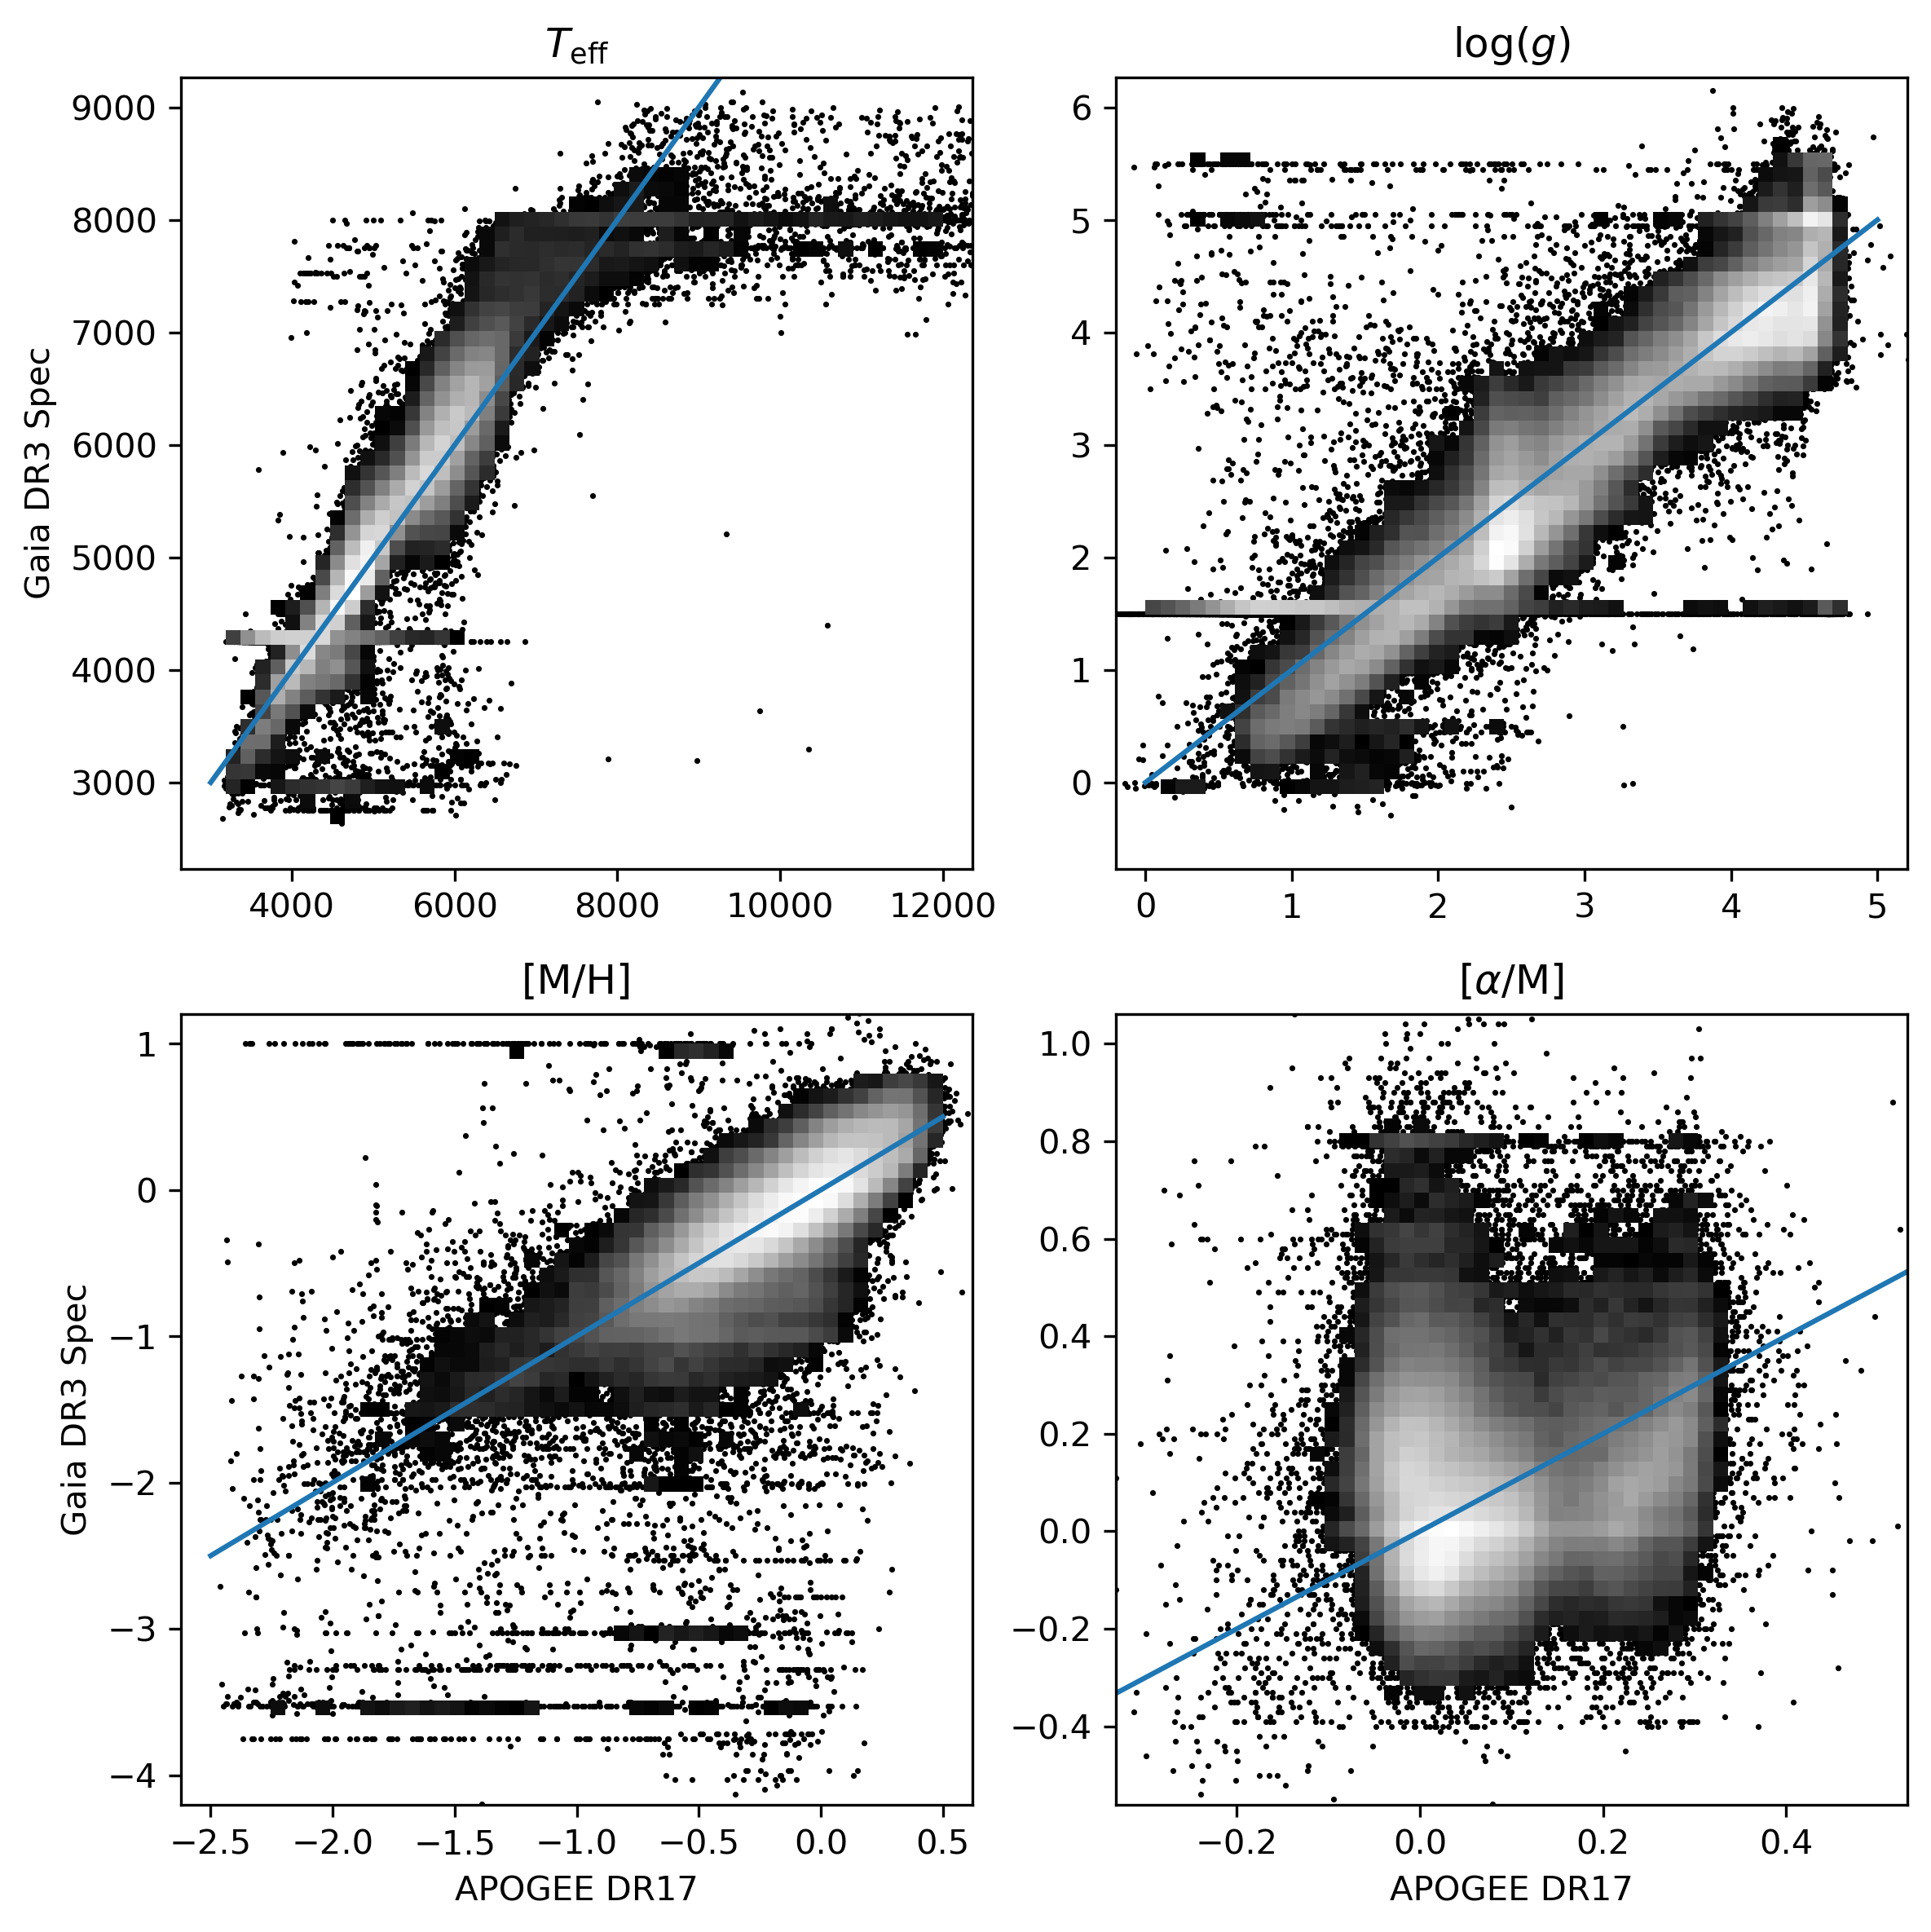

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=300, tight_layout=True)

scatter_hist(axs[0,0], alldata["TEFF"], alldata["teff_gspspec"], 
             xlim=(3000, 12000), ylim=(2500, 9000))
axs[0,0].plot([3000, 10000], [3000, 10000])
axs[0,0].set_title(r"$T_{\rm{eff}}$")
axs[0,0].set_ylabel("Gaia DR3 Spec")

scatter_hist(axs[0,1], alldata["LOGG"], alldata["logg_gspspec"], 
             xlim=(0, 5), ylim=(-0.5, 6))
axs[0,1].plot([0, 5], [0, 5])
axs[0,1].set_title(r"$\log(g)$")

scatter_hist(axs[1,0], alldata["M_H"], alldata["mh_gspspec"], 
             xlim=(-2.5, 0.5), ylim=(-4, 1))
axs[1,0].plot([-2.5, 0.5], [-2.5, 0.5])
axs[1,0].set_xlabel("APOGEE DR17")
axs[1,0].set_ylabel("Gaia DR3 Spec")
axs[1,0].set_title("[M/H]")

scatter_hist(axs[1,1], alldata["ALPHA_M"], alldata["alphafe_gspspec"],
             xlim=(-0.3, 0.5), ylim=(-0.5, 1))
axs[1,1].plot([-0.5, 1], [-0.5, 1])
axs[1,1].set_title(r"[$\alpha$/M]")
axs[1,1].set_xlabel("APOGEE DR17")

plt.show()

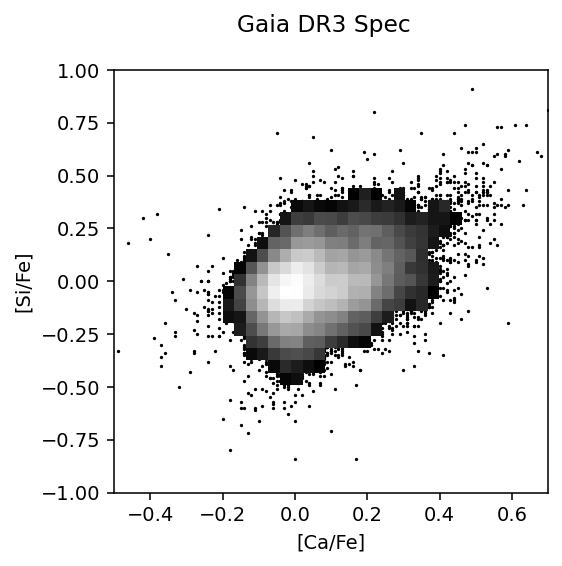

In [84]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
scatter_hist(ax, alldata["cafe_gspspec"], alldata["sife_gspspec"])
ax.set_xlim((-0.5, 0.7))
ax.set_ylim((-1, 1))
ax.set_xlabel("[Ca/Fe]")
ax.set_ylabel("[Si/Fe]")
fig.suptitle("Gaia DR3 Spec")
plt.show()

Looking into the horizontal lines in the above Teff, logg plots.
Teff=4250, logg=1.5

In [25]:
gridpt = alldata[(alldata["teff_gspspec"] > 4249) & 
                 (alldata["teff_gspspec"] < 4251) &
                 (alldata["logg_gspspec"] > 1.49) & 
                 (alldata["logg_gspspec"] < 1.51)]
gridpt

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,ag_msc_upper,ag_msc_lower,logposterior_msc,mcmcaccept_msc,mcmcdrift_msc,flags_msc,neuron_oa_id,neuron_oa_dist,neuron_oa_dist_percentile_rank,flags_oa
00000317+5821383,2M00000317+5821383,apo25m,116-04,none,0.013232,58.360649,116.219079,-3.839647,8.206,0.021,...,0.434640,0.394134,-631796.70,0.250286,0.490318,1.0,NaN,NaN,NaN,NaN
00001493+5534446,2M00001493+5534446,apo25m,NGC7789_btx,none,0.062212,55.579067,115.691312,-6.571265,10.372,0.021,...,0.644184,0.611617,-131149.17,0.287255,1.931853,1.0,NaN,NaN,NaN,NaN
00002903+6403157,2M00002903+6403157,apo25m,117+01,none,0.120994,64.054382,117.393251,1.732085,9.043,0.030,...,0.731711,0.704697,-917079.50,0.297112,0.328657,1.0,NaN,NaN,NaN,NaN
00004072+5714404,2M00004072+5714404,apo25m,N7789,none,0.169704,57.244583,116.080233,-4.950229,9.945,0.024,...,0.679630,0.269145,-283432.20,0.215370,0.072109,1.0,NaN,NaN,NaN,NaN
00004297+5739255,2M00004297+5739255,apo25m,116-04,none,0.179078,57.657097,116.166372,-4.546713,9.606,0.027,...,0.932930,0.926855,-521472.56,0.260167,6.725699,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23592548+5741219,2M23592548+5741219,apo25m,N7789,none,359.856167,57.689442,116.003041,-4.480748,8.256,0.023,...,0.316499,0.297866,-675259.50,0.336778,1.044637,1.0,NaN,NaN,NaN,NaN
23592841+6335256,2M23592841+6335256,apo25m,117+01,none,359.868413,63.590454,117.192001,1.299451,10.309,0.023,...,0.603818,0.574670,-292717.75,0.253842,0.884433,1.0,NaN,NaN,NaN,NaN
23593029+5720145,2M23593029+5720145,apo25m,116-04,none,359.876209,57.337372,115.942704,-4.827812,10.261,0.026,...,0.528305,0.506645,-219340.25,0.265513,1.346219,1.0,NaN,NaN,NaN,NaN
23593407+6302141,2M23593407+6302141,apo25m,117+01,none,359.891977,63.037251,117.091755,0.755300,10.326,0.022,...,0.520132,0.509780,-121168.04,0.279451,1.260397,1.0,NaN,NaN,NaN,NaN


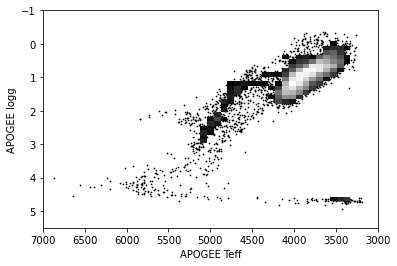

In [37]:
fig, ax = plt.subplots()
scatter_hist(ax, gridpt["TEFF"], gridpt["LOGG"], ylim=(-1, 5.5), xlim=(3000, 7000))
ax.set_ylim((5.5, -1))
ax.set_xlim((7000, 3000))
ax.set_xlabel("APOGEE Teff")
ax.set_ylabel("APOGEE logg")
plt.show()

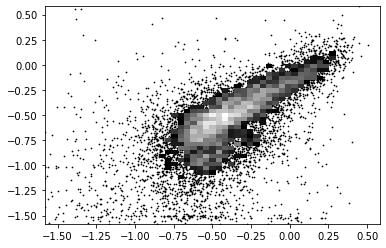

In [50]:
fig, ax = plt.subplots()
scatter_hist(ax, gridpt["M_H"], gridpt["mh_gspspec"], xlim=(-1.5, 0.5), ylim=(-1.5, 0.5))
plt.show()

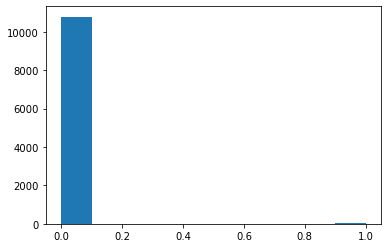

In [46]:
plt.hist(gridpt["classprob_dsc_combmod_binarystar"])
plt.show()

In [47]:
gridpt[gridpt["classprob_dsc_combmod_binarystar"] > 1e-2]["classprob_dsc_combmod_binarystar"]

04273624-5921158    0.999999
04534379-5836247    0.999999
04593230-6153042    0.999999
05061038-5828287    0.999999
05162406-7630203    0.999999
06334177-7658087    0.999999
06421118+0334527    0.999999
07260282-6302419    0.999999
07351136+4256551    0.999999
08284668+5047332    0.999999
08401597+3127068    0.999999
08545875+0046325    0.999999
09202135+3221478    0.999999
12244807+4726354    0.999999
12291453+5332448    0.999999
14130286+0506321    0.999999
14500116+5340097    0.999999
15300194+4421560    0.999999
16155118+3157190    0.999999
16252989+2658228    0.999999
16390758+3037185    0.999999
16560693-0349583    0.999999
17224300+6008212    0.999999
17300615+5439318    0.999999
19335259+4839279    0.999999
23315208+1956142    0.999999
Name: classprob_dsc_combmod_binarystar, dtype: float64

In [53]:
gridpt["flags_gspspec"]

00000317+5821383    01100011000029999999999999999999999999999
00001493+5534446    00000000000019999999900999999999999999999
00002903+6403157    10000131000019999999999999999999999999999
00004072+5714404    00000212000029999999999999999999999999999
00004297+5739255    00000031000029999999999999999999999999999
                                      ...                    
23592548+5741219    01100032000029999999999999999999999999999
23592841+6335256    01100021000029999999999999999999999999999
23593029+5720145    00000031000029999999999999999999999999999
23593407+6302141    00100031000029999999999999999999999999999
23595484+5711289    00100011000029999999999999999999999999999
Name: flags_gspspec, Length: 10808, dtype: object

In [56]:
[f for f in gridpt["flags_gspspec"] if '9' in f[:13]]

['10221931000019999999999999999999999999999',
 '20221931000019999999999999999999999999999',
 '21901152000019999999999999999999999999999',
 '00021951000019999999999999999999999999999',
 '00021951000029999999999999999999999999999',
 '21921131000019999999999999999999999999999',
 '00022931000019999999999999999999999999999',
 '00021951000019999999999999999999999999999',
 '22900131000029999999999999999999999999999',
 '10221951000019999999999999999999999999999']

Recreation of the high-quality sample from the chemical cartography paper

In [97]:
alldata[pd.isna(alldata["flags_gspspec"])]

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,ag_msc_upper,ag_msc_lower,logposterior_msc,mcmcaccept_msc,mcmcdrift_msc,flags_msc,neuron_oa_id,neuron_oa_dist,neuron_oa_dist_percentile_rank,flags_oa
00000035-7323394,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,0.768308,0.000000,102.58035,0.230191,0.071842,0.0,NaN,NaN,NaN,NaN
00000133+5721163,2M00000133+5721163,apo25m,NGC7789_btx,none,0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,0.470687,0.321308,-3328.14500,0.297279,0.303453,1.0,NaN,NaN,NaN,NaN
00000211+6327470,2M00000211+6327470,apo25m,117+01,none,0.008802,63.463078,117.227985,1.162167,11.880,0.024,...,0.993266,0.624492,-12190.11000,0.313079,0.285785,1.0,NaN,NaN,NaN,NaN
00000222+5625359,2M00000222+5625359,apo25m,N7789,none,0.009287,56.426662,115.831519,-5.734687,11.982,0.023,...,0.307246,0.172554,-15026.95300,0.225370,0.179776,1.0,NaN,NaN,NaN,NaN
00000446+5854329,2M00000446+5854329,apo25m,116-04,none,0.018603,58.909149,116.330761,-3.302585,12.255,0.023,...,0.565865,0.545288,-18014.79300,0.316086,2.942031,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23595837+5700444,2M23595837+5700444,apo25m,N7789,none,359.993224,57.012356,115.939899,-5.158948,12.657,0.026,...,0.693844,0.494217,-4813.51460,0.260072,0.318738,1.0,NaN,NaN,NaN,NaN
23595867-7339039,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,0.409695,0.000000,151.24228,0.262053,0.098688,0.0,NaN,NaN,NaN,NaN
23595886+5726058,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,0.439536,0.420394,-29813.63300,0.299332,0.678233,1.0,NaN,NaN,NaN,NaN
23595921+5609479,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,2.164036,0.091880,-16314.74500,0.240167,0.105819,1.0,NaN,NaN,NaN,NaN


In [16]:
# Select only targets with GSPSpec data
gspspec = alldata[pd.notna(alldata["flags_gspspec"])]
# Same cuts as in Appendix B
hiq = gspspec[(gspspec["teff_gspspec"] > 3500) &
              (gspspec["logg_gspspec"] > 0) &
              (gspspec["logg_gspspec"] < 5) &
              (gspspec["flags_gspspec"].str[:7]=='0000000') &
              (gspspec["flags_gspspec"].str[7].astype(int) < 3) &
              (gspspec["flags_gspspec"].str[12].astype(int) < 2) &
              (gspspec["flags_gspspec"].str[8:12] == '0000')]
hiq

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,azero_gspphot_source,azero_gspphot_lower_source,azero_gspphot_upper_source,ag_gspphot_source,ag_gspphot_lower_source,ag_gspphot_upper_source,ebpminrp_gspphot_source,ebpminrp_gspphot_lower_source,ebpminrp_gspphot_upper_source,libname_gspphot_source
00000002+7417074,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,1.9282,1.8881,1.9881,1.2574,1.2309,1.2965,0.7237,0.7098,0.7447,MARCS
00000233+1452324,2M00000233+1452324,apo25m,105-45,none,0.009748,14.875667,104.845530,-46.183158,10.649,0.022,...,0.0732,0.0644,0.0818,0.0566,0.0497,0.0633,0.0294,0.0258,0.0329,PHOENIX
00000506+5656353,2M00000506+5656353,apo25m,NGC7789_btx,none,0.021113,56.943142,115.941040,-5.229802,9.317,0.026,...,1.0286,0.9740,1.2367,0.7980,0.7540,0.9688,0.4318,0.4080,0.5293,PHOENIX
00000546+6152107,2M00000546+6152107,apo25m,116+00,none,0.022759,61.869644,116.918992,-0.401038,9.013,0.063,...,2.8291,2.8059,2.8376,2.0415,2.0233,2.0482,1.0828,1.0723,1.0865,MARCS
00000866+7122144,2M00000866+7122144,apo25m,120+08,none,0.036099,71.370689,118.816522,8.910097,9.795,0.023,...,2.1394,2.1327,2.1586,1.5830,1.5777,1.5985,0.8414,0.8384,0.8497,MARCS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23595157+5607093,2M23595157+5607093,apo25m,NGC7789_MGA,none,359.964912,56.119274,115.745654,-6.030996,9.773,0.022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23595453+5618262,2M23595453+5618262,apo25m,NGC7789_MGA,none,359.977248,56.307304,115.790143,-5.848118,9.920,0.026,...,0.8501,0.8472,0.8532,0.6444,0.6421,0.6468,0.3433,0.3420,0.3447,MARCS
23595490+5704387,2M23595490+5704387,apo25m,N7789,none,359.978770,57.077431,115.945170,-5.093610,9.307,0.024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23595606+6251121,2M23595606+6251121,apo25m,116+00,none,359.983620,62.853386,117.096010,0.566818,10.875,0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


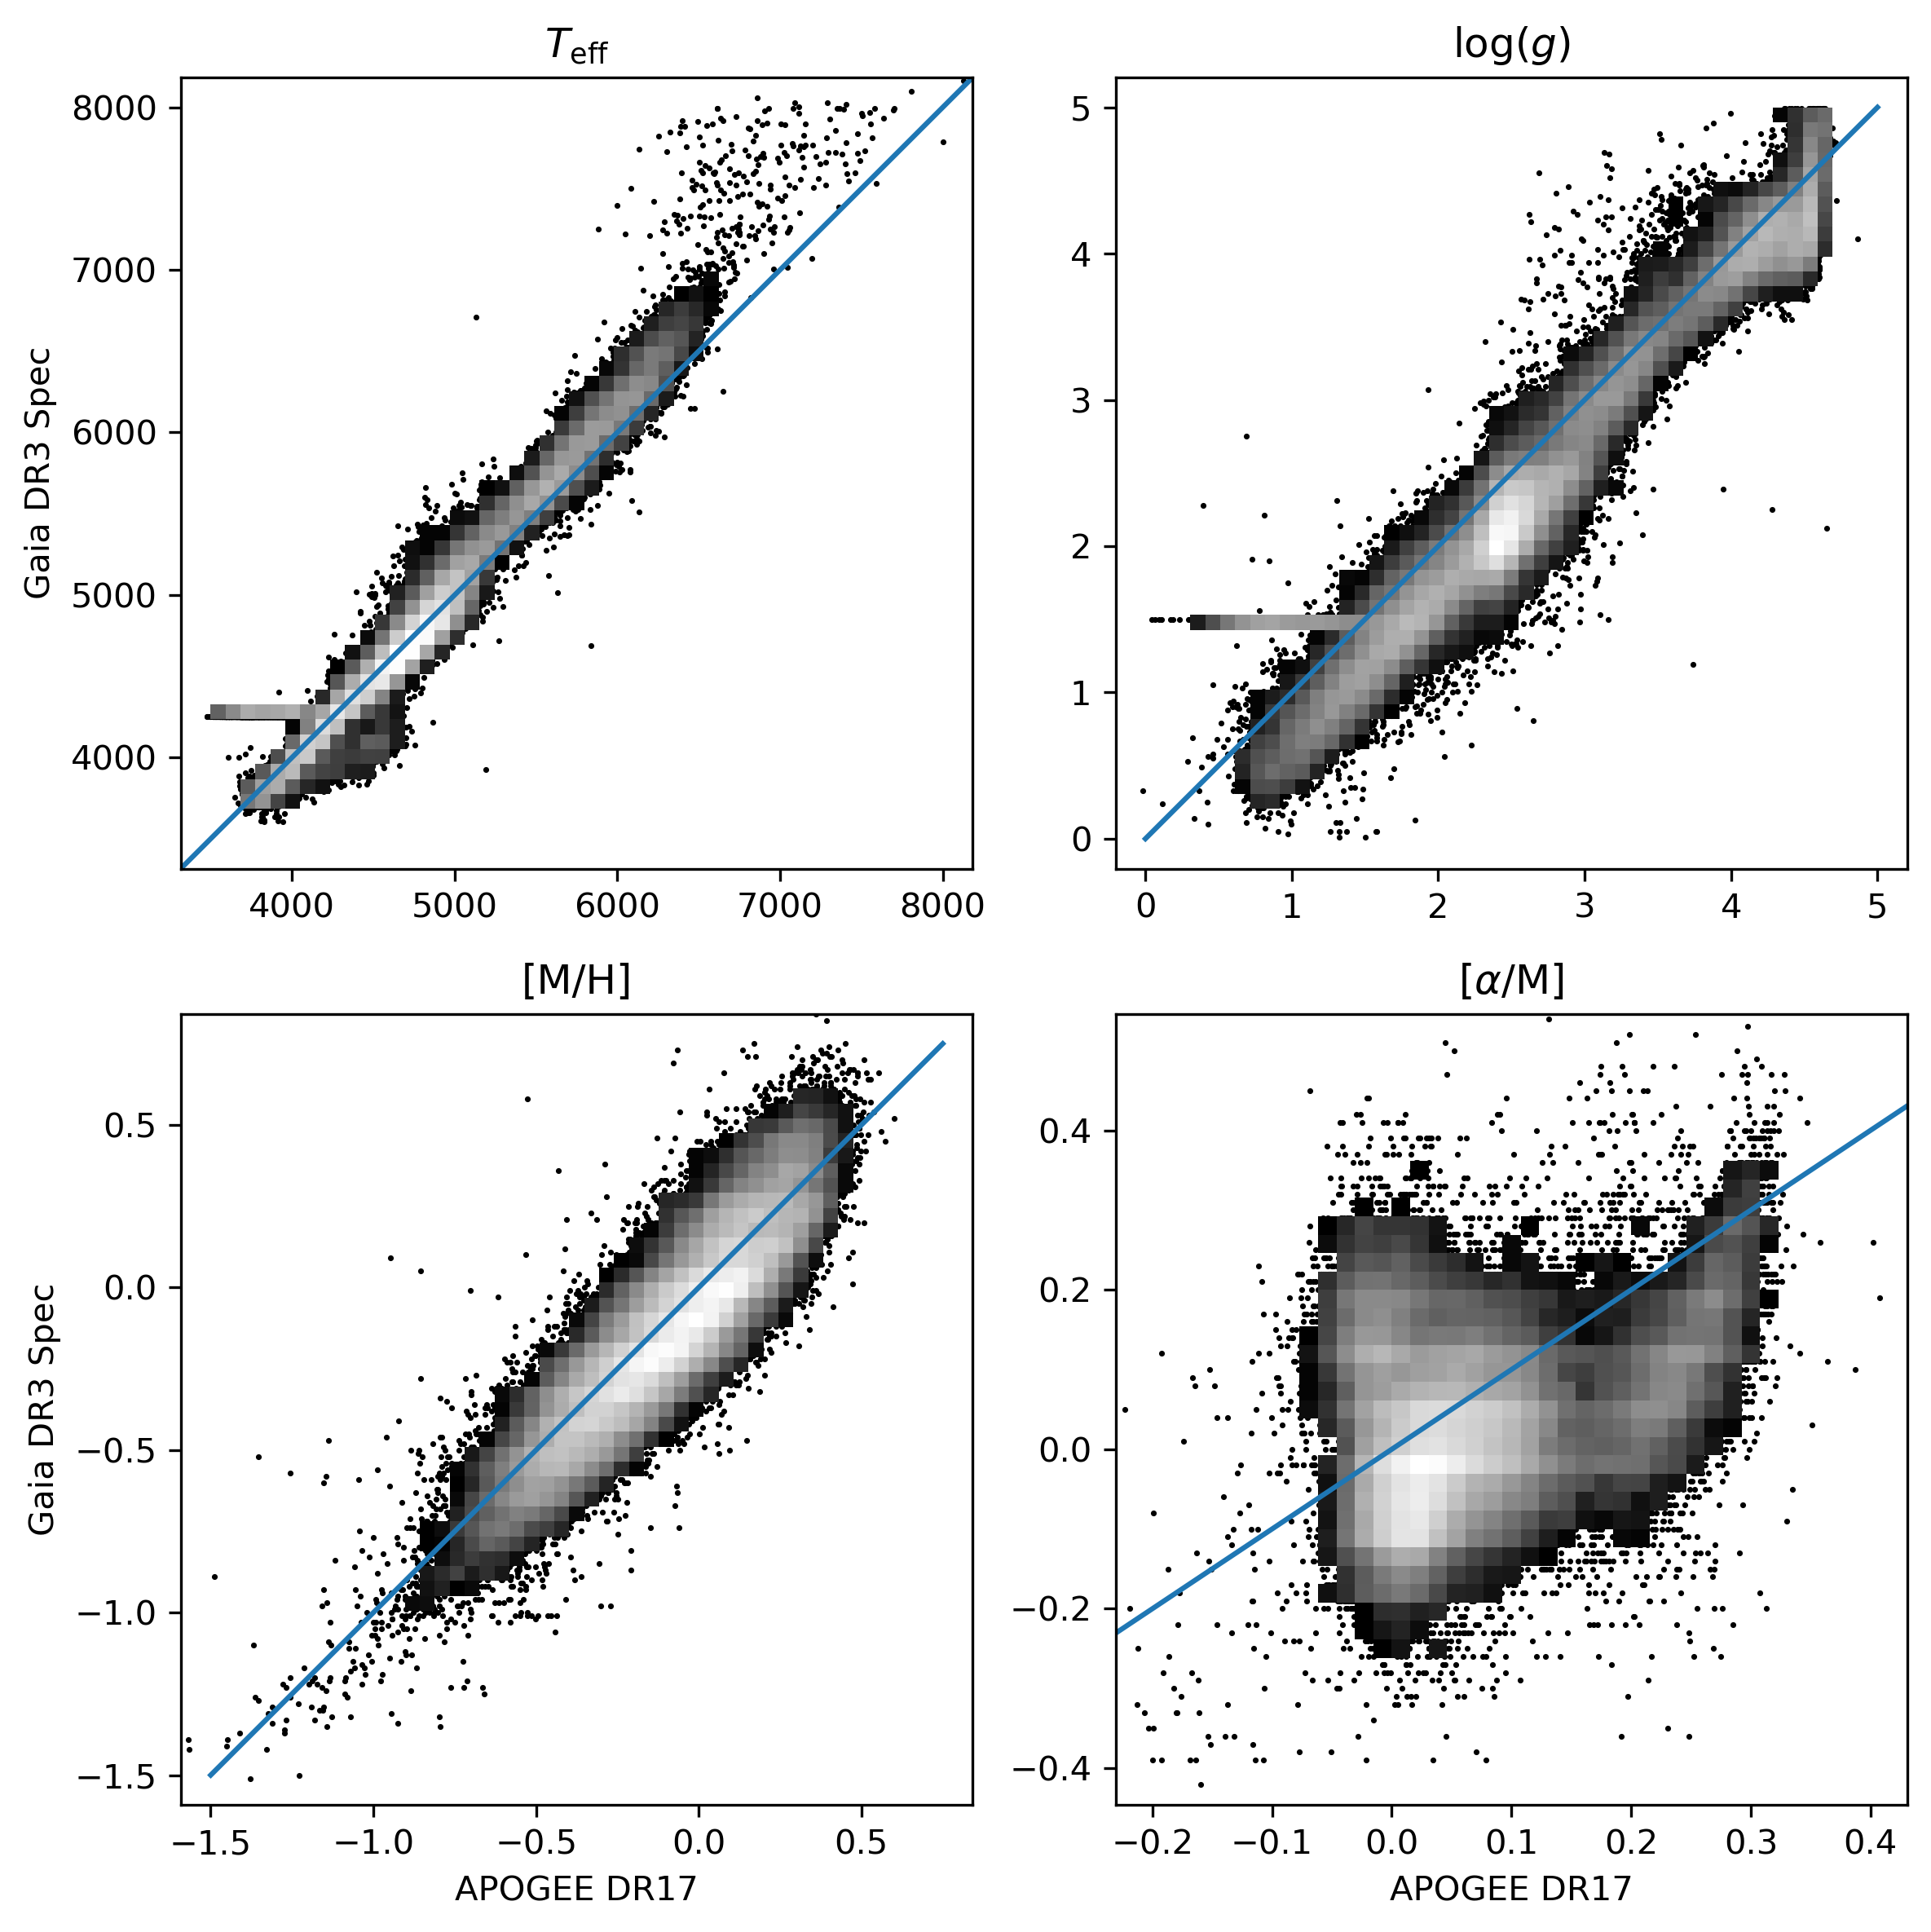

In [116]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=300, tight_layout=True)

scatter_hist(axs[0,0], hiq["TEFF"], hiq["teff_gspspec"], 
             xlim=(3500, 8000), ylim=(3500, 8000))
axs[0,0].plot([3000, 10000], [3000, 10000])
axs[0,0].set_title(r"$T_{\rm{eff}}$")
axs[0,0].set_ylabel("Gaia DR3 Spec")

scatter_hist(axs[0,1], hiq["LOGG"], hiq["logg_gspspec"], 
             xlim=(0, 5), ylim=(0, 5))
axs[0,1].plot([0, 5], [0, 5])
axs[0,1].set_title(r"$\log(g)$")

scatter_hist(axs[1,0], hiq["M_H"], hiq["mh_gspspec"], 
             xlim=(-1.5, 0.75), ylim=(-1.5, 0.75))
axs[1,0].plot([-1.5, 0.75], [-1.5, 0.75])
axs[1,0].set_xlabel("APOGEE DR17")
axs[1,0].set_ylabel("Gaia DR3 Spec")
axs[1,0].set_title("[M/H]")

scatter_hist(axs[1,1], hiq["ALPHA_M"], hiq["alphafe_gspspec"],
             xlim=(-0.2, 0.4), ylim=(-0.4, 0.5), nbins=40)
axs[1,1].plot([-0.5, 1], [-0.5, 1])
axs[1,1].set_title(r"[$\alpha$/M]")
axs[1,1].set_xlabel("APOGEE DR17")

plt.show()

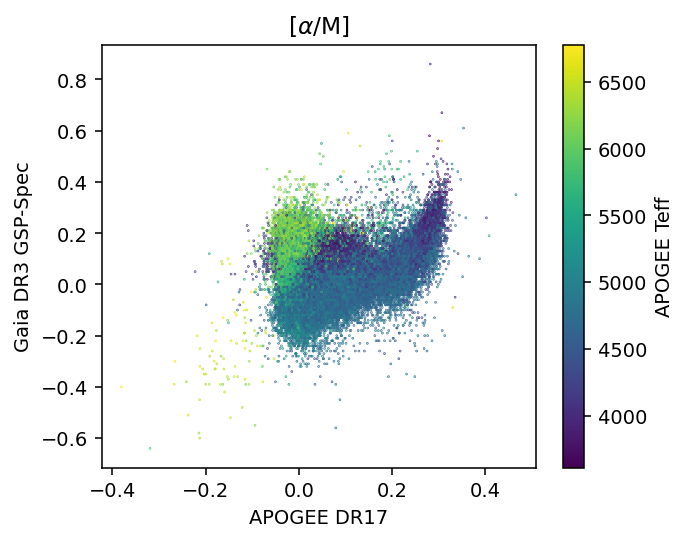

In [74]:
fig, ax = plt.subplots(dpi=140, figsize=(5, 4))
pc = ax.scatter(hiq["ALPHA_M"], hiq["alphafe_gspspec"], s=0.1, c=hiq["TEFF"])
fig.colorbar(pc, label="APOGEE Teff")
ax.set_xlabel("APOGEE DR17")
ax.set_ylabel("Gaia DR3 GSP-Spec")
ax.set_title(r"[$\alpha$/M]")
plt.show()

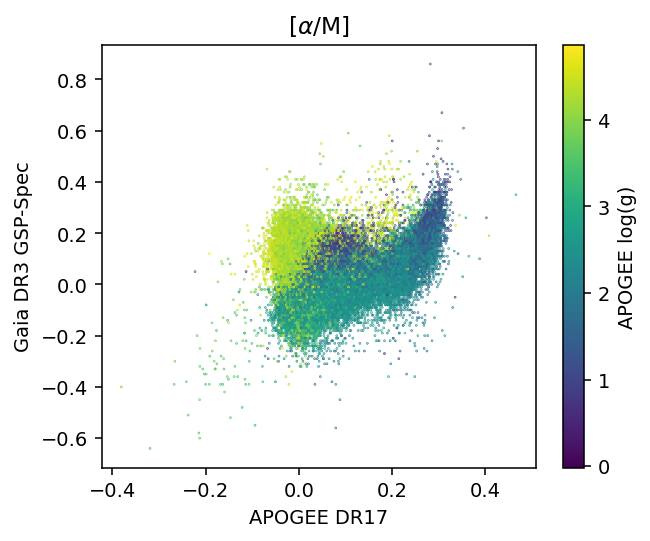

In [75]:
fig, ax = plt.subplots(dpi=140, figsize=(5, 4))
pc = ax.scatter(hiq["ALPHA_M"], hiq["alphafe_gspspec"], s=0.1, c=hiq["LOGG"])
fig.colorbar(pc, label="APOGEE log(g)")
ax.set_xlabel("APOGEE DR17")
ax.set_ylabel("Gaia DR3 GSP-Spec")
ax.set_title(r"[$\alpha$/M]")
plt.show()

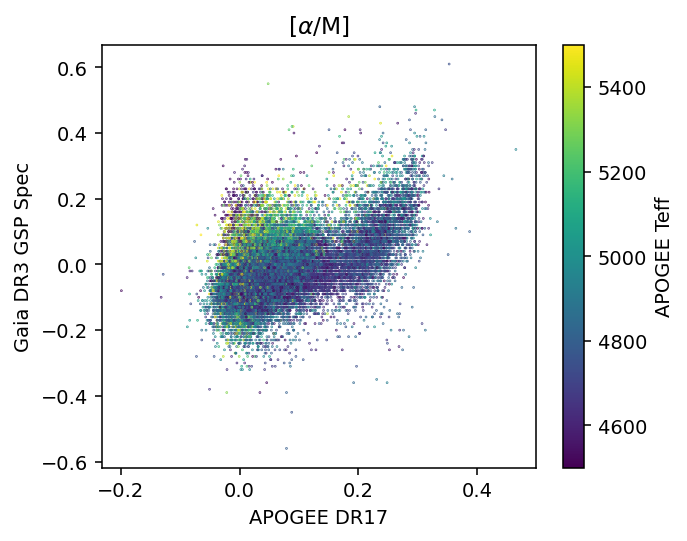

In [133]:
df = hiq[(hiq["TEFF"] > 4500) & (hiq["TEFF"] < 5500)]
fig, ax = plt.subplots(dpi=140, figsize=(5, 4))
pc = ax.scatter(df["ALPHA_M"], df["alphafe_gspspec"], s=0.1, c=df["TEFF"])
fig.colorbar(pc, label="APOGEE Teff")
ax.set_xlabel("APOGEE DR17")
ax.set_ylabel("Gaia DR3 GSP Spec")
ax.set_title(r"[$\alpha$/M]")
plt.show()

Cluster membership

In [17]:
occam_member = Table.read("data/occam_member-DR17.fits", format="fits")
occam_df = decode(occam_member.to_pandas())
occam_df

,CLUSTER,APOGEE_ID,LOCATION_ID,GLON,GLAT,VHELIO_AVG,VSCATTER,FE_H,FE_H_ERR,PMRA,PMRA_ERR,PMDEC,PMDEC_ERR,RV_PROB,FEH_PROB,PM_PROB,CG_PROB
0,Alessi 57,2M19204583+1541351,5031,50.195928,0.802233,32.87,0.03,0.20,0.01,-3.12,0.06,-3.30,0.06,0.00,0.0,0.00,-9999.99
1,Alessi 57,2M19204998+1540135,5031,50.183748,0.776890,6.33,0.12,0.27,0.01,-1.78,0.03,-4.00,0.03,0.00,0.0,0.00,-9999.99
2,Alessi 57,2M19205008+1540273,5031,50.187298,0.778336,18.72,0.08,-0.04,0.01,-2.13,0.13,-5.57,0.12,1.00,1.0,0.59,-9999.99
3,Alessi 57,2M19205190+1542058,5031,50.214893,0.784750,27.27,0.05,-0.13,0.01,-1.59,0.04,-8.28,0.04,0.00,0.0,0.00,-9999.99
4,Alessi 57,2M19205216+1538195,5031,50.159907,0.754288,-10.81,0.12,-0.29,0.01,2.73,0.01,-6.90,0.02,0.00,0.0,0.00,-9999.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26694,Wit 3,2M07221011-0905413,4582,224.532053,2.602547,118.04,0.05,-0.16,0.01,-0.06,0.01,-0.38,0.01,0.00,0.0,-0.00,-9999.99
26695,Wit 3,2M07221472-0857282,4582,224.419880,2.683599,105.13,0.32,-0.30,0.01,-1.02,0.02,1.07,0.01,0.84,1.0,0.68,-9999.99
26696,Wit 3,2M07222253-0901403,4582,224.496900,2.679103,58.86,3.59,-0.09,0.01,-1.64,0.01,2.40,0.01,0.00,0.0,-0.00,-9999.99
26697,Wit 3,2M07222909-0856255,4582,224.432306,2.743977,84.05,0.43,0.11,0.01,-0.31,0.01,-5.61,0.01,0.00,0.0,-0.00,-9999.99


In [56]:
M67_members = occam_df[(occam_df["CLUSTER"] == "NGC 2682") &
                       (occam_df["CG_PROB"] > 0.5)]
M67_members

,CLUSTER,APOGEE_ID,LOCATION_ID,GLON,GLAT,VHELIO_AVG,VSCATTER,FE_H,FE_H_ERR,PMRA,PMRA_ERR,PMDEC,PMDEC_ERR,RV_PROB,FEH_PROB,PM_PROB,CG_PROB
22458,NGC 2682,2M08492379+1154367,7252,215.349595,31.519294,34.42,0.10,-0.02,0.01,-10.91,0.03,-3.10,0.03,0.98,0.86,0.61,0.7
22460,NGC 2682,2M08492491+1144057,5115,215.538531,31.450138,26.64,5.65,0.06,0.01,-10.98,0.03,-2.79,0.02,0.00,0.35,0.85,0.7
22461,NGC 2682,2M08492523+1145558,7252,215.506638,31.464151,35.08,4.10,-0.03,0.01,-10.73,0.04,-2.91,0.03,0.76,0.77,0.55,0.7
22463,NGC 2682,2M08492885+1140082,6227,215.616640,31.437078,57.63,0.00,0.01,0.01,-10.81,0.03,-2.54,0.03,0.00,0.97,0.14,0.6
22484,NGC 2682,2M08494490+1141562,5115,215.616927,31.509134,35.63,3.17,-0.05,0.01,-10.76,0.04,-3.11,0.03,0.48,0.50,0.39,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23056,NGC 2682,2M08524441+1149029,6294,215.851483,32.223660,NaN,0.00,NaN,NaN,-10.65,0.04,-2.70,0.03,NaN,NaN,0.18,0.7
23057,NGC 2682,2M08524464+1138414,7252,216.037123,32.152098,34.09,0.19,0.04,0.01,-11.03,0.05,-2.61,0.04,1.00,0.61,0.31,0.6
23058,NGC 2682,2M08524511+1147157,7252,215.884871,32.213776,34.98,0.13,-0.14,0.01,-11.46,0.06,-3.34,0.04,0.80,0.00,0.01,0.6
23069,NGC 2682,2M08525625+1148539,6294,215.878078,32.266448,33.13,0.00,0.08,0.01,-11.14,0.02,-2.98,0.01,0.67,0.13,0.63,0.6


In [85]:
M67 = alldata.set_index("APOGEE_ID").join(M67_members.set_index("APOGEE_ID"), how="inner", rsuffix="_OCCAM")
M67.shape

(319, 587)

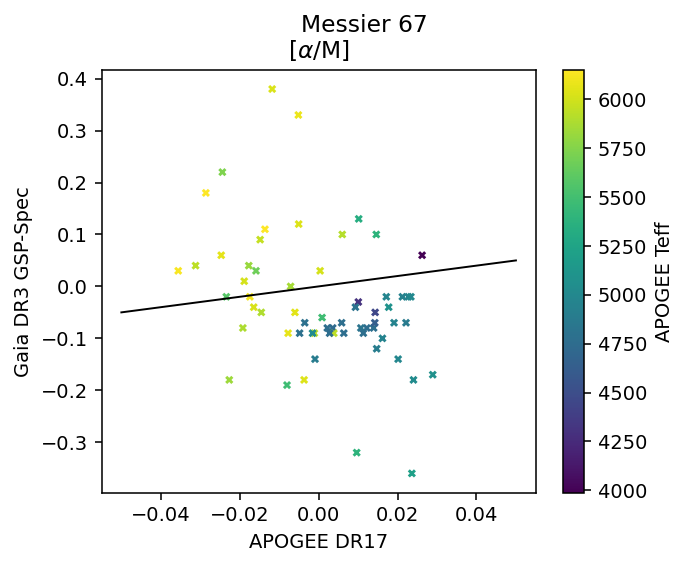

In [88]:
fig, ax = plt.subplots(dpi=140, figsize=(5, 4))
pc = ax.scatter(M67["ALPHA_M"], M67["alphafe_gspspec"], c=M67["TEFF"], s=10, marker='x')
fig.colorbar(pc, label="APOGEE Teff")
ax.plot([-0.05, 0.05], [-0.05, 0.05], c='k', linewidth=1)
ax.set_xlabel("APOGEE DR17")
ax.set_ylabel("Gaia DR3 GSP-Spec")
ax.set_title(r"[$\alpha$/M]")
fig.suptitle("Messier 67")
plt.show()

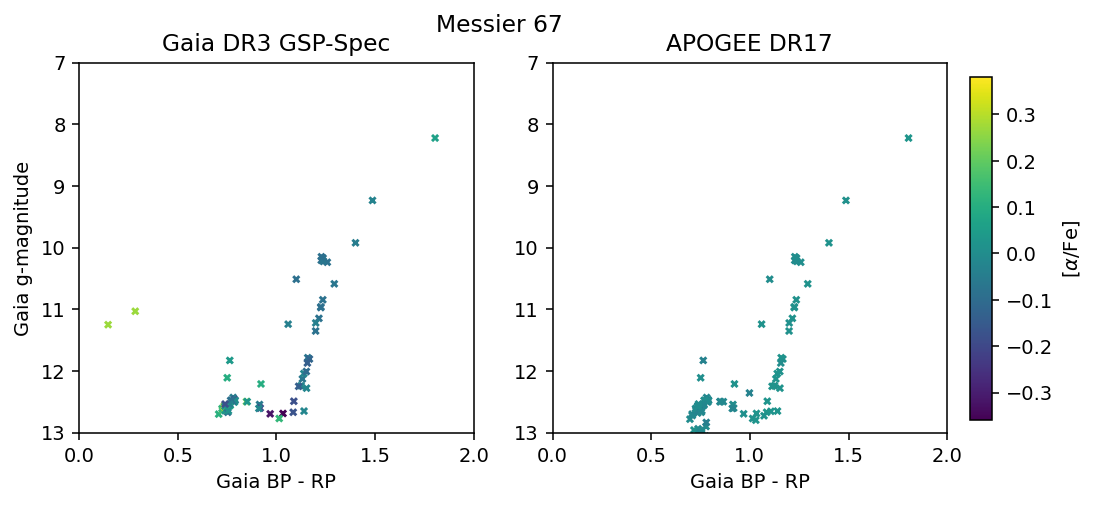

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), dpi=140)

ms = 10

# colorbar
fig.subplots_adjust(right=0.9)
cax = plt.axes([0.92, 0.15, 0.02, 0.7])

pc = axs[0].scatter(M67['bp_rp'], M67['phot_g_mean_mag'], 
               c=M67['alphafe_gspspec'], s=ms, marker='x')
cbar = fig.colorbar(pc, cax, label=r'[$\alpha$/Fe]')
axs[0].set_ylim((13, 7))
axs[0].set_xlim((0, 2))
axs[0].set_xlabel('Gaia BP - RP')
axs[0].set_ylabel('Gaia g-magnitude')
axs[0].set_title('Gaia DR3 GSP-Spec')

axs[1].scatter(M67['bp_rp'], M67['phot_g_mean_mag'], 
               c=M67['ALPHA_M'], s=ms, cmap=cbar.cmap, 
               norm=cbar.norm, marker='x')
axs[1].set_ylim((13, 7))
axs[1].set_xlim((0, 2))
axs[1].set_xlabel('Gaia BP - RP')
axs[1].set_title('APOGEE DR17')

fig.suptitle('Messier 67')
plt.show()